## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-03 22:27:10--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.2’

CreditScoring.csv.2 100%[===================>] 178.21K  --.-KB/s    in 0.02s   

2021-10-03 22:27:10 (11.1 MB/s) - ‘CreditScoring.csv.2’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [8]:
numerical_columns   = df.columns[df.dtypes == 'int64'].values
categorical_columns = df.columns[df.dtypes == 'object'].values
(numerical_columns,categorical_columns)

(array(['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt',
        'amount', 'price', 'default'], dtype=object),
 array(['home', 'marital', 'records', 'job'], dtype=object))

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

res = []
for col in ['seniority','time','income','debt']:
    fpr, tpr, threshold = roc_curve(y_train,df_train[col].values)
    a = auc(fpr,tpr)
    if a < 0.5:
        fpr, tpr, threshold = roc_curve(y_train,-df_train[col].values)
        a = auc(fpr,tpr)
    res.append((col,a))
res

[('seniority', 0.7093778624491943),
 ('time', 0.5608662489595051),
 ('income', 0.682006666132633),
 ('debt', 0.5047829675783548)]

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [11]:
model_columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']

dv = DictVectorizer(sparse=False)

train_dict = df_train[model_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[model_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
round(auc(fpr, tpr),3)

0.812

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [12]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores['precision'] = df_scores['tp'] / (df_scores['tp']+df_scores['fp'])
df_scores['recall']    = df_scores['tp'] / (df_scores['tp']+df_scores['fn'])

df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,246,645,0,0,0.276094,1.000000
10,0.1,235,445,11,200,0.345588,0.955285
20,0.2,215,267,31,378,0.446058,0.873984
30,0.3,187,162,59,483,0.535817,0.760163
40,0.4,140,100,106,545,0.583333,0.569106
50,0.5,114,64,132,581,0.640449,0.463415
60,0.6,78,38,168,607,0.672414,0.317073
70,0.7,37,16,209,629,0.698113,0.150407
80,0.8,21,5,225,640,0.807692,0.085366
90,0.9,6,2,240,643,0.750000,0.024390


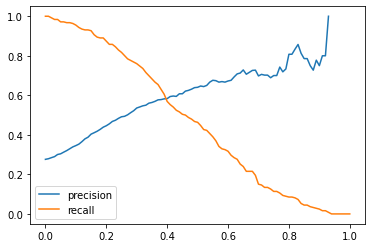

In [13]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall']   , label='recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

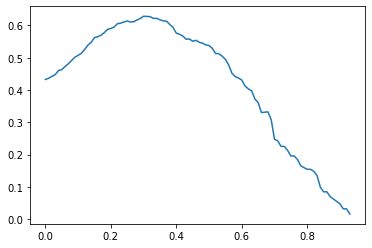

In [14]:
df_scores['F1'] = 2 * df_scores['precision'] * df_scores['recall'] / (df_scores['precision'] + df_scores['recall'])

plt.plot(df_scores.threshold, df_scores['F1'])

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [15]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[model_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[model_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

n_splits = 5
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.808 +- 0.012
C=0.1 0.813 +- 0.014
C=1 0.814 +- 0.015
C=10 0.814 +- 0.015


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.